<a href="https://colab.research.google.com/github/YMGYM/google_colab_files/blob/master/Image_Text_Embedding_with_tsne.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

투빅스 12회 추천 컨퍼런스 Img2Seq(Show And Tell) 의 코드 정리입니다.

`Kor2Vec` 과 `pytorch` 를 사용했습니다.

# 기본 다운로드 및 임포트

In [1]:
!pip install git+https://github.com/naver/kor2vec.git

  Cloning https://github.com/naver/kor2vec.git to /tmp/pip-req-build-wo4e0vt7
  Running command git clone -q https://github.com/naver/kor2vec.git /tmp/pip-req-build-wo4e0vt7
  Created wheel for kor2vec: filename=kor2vec-1.0.1-cp37-none-any.whl size=21946 sha256=5c33af7667052f854b8078119008b9b3be4fc146ab9b58e0dcab1c3815f7b1ca
  Stored in directory: /tmp/pip-ephem-wheel-cache-yx41a_j6/wheels/b7/74/03/492f7af08e1f00c56765b0f6a25f28a086cc23db1827f269a4
Successfully built kor2vec


In [3]:
from kor2vec import Kor2Vec # Kor2Vec import

import pandas as pd
import numpy as np
import os
from PIL import Image
import torch
import torchvision.models as models # 임베딩 모델
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# 기본 변수 정의

In [4]:
# 리뷰 테이블 읽어오기
review = pd.read_csv('/content/drive/MyDrive/Datasets/cafe_review_tag.csv', encoding='cp949')

In [7]:
# 없는 파일 인덱스 파악
result = []
all_img = [f for f in os.listdir('/content/data') if os.path.isfile(os.path.join('/content/data', f))]

for idx, imgName in enumerate(review['imgname_123']):
  if imgName not in all_img or imgName == 'desktop.ini':
    result.append(idx)


result

[197, 754, 4470, 4641, 5248]

In [8]:
# 잘못된 이미지 파일 제거
review.drop(result, inplace=True)
review.dropna(inplace=True)
review = review.reset_index(drop = True)

In [9]:
# 리뷰 데이터를 사용해 임베딩을 학습 실시

rev = pd.Series("<sos> " + review['review'])
rev.to_csv("review_corpus.csv")


kor2vec = Kor2Vec(embed_size=64) # embed_size : 임베딩 벡터의 2번째 차원(차원 수)
"""
train([텍스트 데이터 파일 - 위에서 저장, 모델 저장 위치, 학습 배치 사이즈])
"""
kor2vec.train("review_corpus.csv", 'model.kor2vec', batch_size=128) # 임베딩 실시 (학습)
kor2vec.save("/content/drive/MyDrive/koremb_tobigs/embedding") # 임베딩 모델 저장

Corpus Sampling:   0%|          | 0/19833 [00:00<?, ?it/s]

Reading Corpus lines


Corpus Sampling: 100%|██████████| 19833/19833 [00:00<00:00, 35530.78it/s]


Training kor2vec
Loading Word_sample corpus
Loading corpus finished
CUDA Available/count: True 1
training on  cuda:0


KeyboardInterrupt: ignored

In [6]:
!unzip -O euc-kr -q /content/drive/MyDrive/Datasets/img_preprocess_final_20210615.zip -d data

17번가_1.jpg:  mismatching "local" filename (17踰媛_1.jpg),
         continuing with "central" filename version
17번가_2.jpg:  mismatching "local" filename (17踰媛_2.jpg),
         continuing with "central" filename version
17번가_3.jpg:  mismatching "local" filename (17踰媛_3.jpg),
         continuing with "central" filename version
1945카페_1.jpg:  mismatching "local" filename (1945移댄_1.jpg),
         continuing with "central" filename version
1945카페_2.jpg:  mismatching "local" filename (1945移댄_2.jpg),
         continuing with "central" filename version
1945카페_3.jpg:  mismatching "local" filename (1945移댄_3.jpg),
         continuing with "central" filename version
298카페_1.jpg:  mismatching "local" filename (298移댄_1.jpg),
         continuing with "central" filename version
298카페_2.jpg:  mismatching "local" filename (298移댄_2.jpg),
         continuing with "central" filename version
298카페_3.jpg:  mismatching "local" filename (298移댄_3.jpg),
         continuing with "central" filename 

In [20]:
class CaptionDataset(Dataset):
    """
    root_dir : 이미지 파일이 있는 경로
    captions_file : 이미지 제목-리뷰가 포함된 데이터프레임
    transform : 이미지를 텐서로 변환할 때 transform (optional)
    """
    def __init__(self, img_dir, caption_df, transform=None):
        self.root_dir = img_dir
        self.transform = transform
        self.df = caption_df
        
        self.imgs = self.df['imgname_123'] # 이미지 파일 경로
        self.captions = self.df["review"] # 리뷰 데이터
        self.kor2vec = Kor2Vec.load("/content/drive/MyDrive/koremb_tobigs/embedding") # Kor2Vec 로드
        
    
    def __len__(self):
        return len(self.df)
    
    # 이미지, 텍스트를 불러 오는 메소드
    # transform을 선언하면 임베딩 벡터와 1개 배치로 반환하며, 선언하지 않으면 이미지와 스트링 형태의 캡션을 반환합니다.
    def __getitem__(self,idx):
        caption = self.captions[idx] # target caption
        
        img_name = self.imgs[idx] # 이미지 이름 파일 불러오기
        img_location = os.path.join(self.root_dir,img_name) # 실제로 이미지 오픈
        img = Image.open(img_location).convert("RGB")
        
        # transform이 있다면 실시 후 배치화(1 차원 추가)
        if self.transform is not None:
          img = self.transform(img)
          # 정답 임베딩 데이터 
          # seq_len을 15로 통일하고자 합니다.
          caption = self.kor2vec.embedding(caption, seq_len=15)

        return img, caption

이걸 구현해 보려는 시도
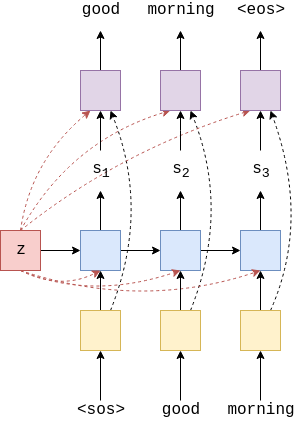

In [11]:
# from https://github.com/bentrevett/pytorch-seq2seq/blob/master/2%20-%20Learning%20Phrase%20Representations%20using%20RNN%20Encoder-Decoder%20for%20Statistical%20Machine%20Translation.ipynb
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, dropout):
        super().__init__()
        self.hid_dim = hid_dim
        self.output_dim = output_dim
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim + hid_dim, hid_dim)
        self.fc_out = nn.Linear(emb_dim + hid_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)

        self.kor2vec = Kor2Vec.load("/content/drive/MyDrive/koremb_tobigs/embedding")

    def forward(self, input, hidden, context):
        
        #input = [batch_size]
        #hidden = [n layers * n directions, batch size, hid dim]
        #context = [n layers * n directions, batch size, hid dim]
        
        #n layers and n directions in the decoder will both always be 1, therefore:
        #hidden = [1, batch size, hid dim]
        #context = [1, batch size, hid dim]
        
        embedded = self.dropout(input)
        
        #embedded = [1, batch size, emb dim]
        emb_con = torch.cat((embedded, context), dim = 2)
            
        #emb_con = [1, batch size, emb dim + hid dim]
            
        output, hidden = self.rnn(emb_con, hidden)
      
        #output = [seq len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        
        #seq len, n layers and n directions will always be 1 in the decoder, therefore:
        #output = [1, batch size, hid dim]
        #hidden = [1, batch size, hid dim]
        
        output = torch.cat((embedded.squeeze(0), hidden.squeeze(0), context.squeeze(0)), 
                           dim = 1)
        
        #output = [batch size, emb dim + hid dim * 2]
        
        prediction = self.fc_out(output)
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden

In [12]:
class Net(nn.Module):
  """
  신경망 파일
  hidden_size : kor2vec의 embedding size 로 맞춰야 합니다.
  """
  def __init__(self, seq_len = 1, embedding_size = 64, hidden_size = 1000):
    super(Net, self).__init__()
    self.seq_len = seq_len
    self.embedding_size = embedding_size
    self.hidden_size = hidden_size
    self.resnet = models.resnet18(pretrained=True)
    self.decoder = Decoder(64, 64, 1000, 0.5)
    self.kor2vec = Kor2Vec.load("/content/drive/MyDrive/koremb_tobigs/embedding")

    # resNet의 모든 파라미터를 잠그고 마지막 레이어만 얼리지 않고 사용합니다.
    for param in self.resnet.parameters():
       param.requires_grad = False
    self.resnet.fc.requires_grad = True # 마지막 레이어만 다시 사용합니다.

  def forward(self, x):
    x = self.resnet(x).reshape(1,1,self.hidden_size) # resnet 통과 output: (batch, hidden)

    hidden = x # lstm의 초기 셀 값은 resNet의 출력입니다.
    outputs = torch.zeros(self.seq_len, 1, self.embedding_size).to(device) # sequence를 저장하기 위한 빈 배열
    

    # <sos> 를 시작 토큰으로 설정합니다.
    output = self.kor2vec.embedding('<sos>').reshape(1, 1, self.embedding_size).to(device)

    # seq 결과물을 lstm의 입력으로 사용하여 seq_len = 15 만큼 반복하여 저장합니다.
    for t in range(0, self.seq_len):
        output, hidden = self.decoder(output, hidden, x ) 
        outputs[t] = output
        output = output.unsqueeze(0)

    return outputs # shape: (15, 1, 1000)

# 실제 코드 불러와서 사용

옆에 이디야보다 아아 가격이 저렴해서 괜찮아요. 쿠키는 사람들이 안먹어서 먼지가..


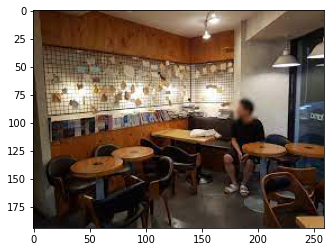

In [ ]:
# 이미지 표시 : transform을 None으로 놓고 사용
img_data = CaptionDataset('/content/data', review, transform=None)
img, rev = img_data[6666]

print(rev)
plt.imshow(img)
plt.show()

In [21]:

transform = transforms.Compose(
    [transforms.ToTensor(), # 텐서로 변형
     transforms.Resize(224), # 사이즈 조절
     transforms.CenterCrop(224), # 가로와 세로 중 안 맞는 곳 자르기
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [22]:
train_data = CaptionDataset('/content/data', review, transform=transform)

img, rev = train_data[0]

print(f"img shape : {img.shape}") # ([1, 3, 224, 224]) - [배치, 채널, 가로, 세로]
print(f"rev : {rev.shape}") # ([15, 1000]) - [seq_len, hidden_size]

img shape : torch.Size([3, 224, 224])
rev : torch.Size([15, 64])


In [23]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)

In [24]:
item, cap = next(iter(train_dataloader))

print(item.shape)

torch.Size([64, 3, 224, 224])


In [ ]:
model = Net()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
model = Net(seq_len=1)


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
model.to(device)

Net(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_

In [ ]:
# 신경망 학습
for epoch in range(2): # 10에포크
  running_loss = 0.0

  for i, data in enumerate(train_data, 0):
    img, label = data[0].to(device), data[1].to(device)
    optimizer.zero_grad()

    output = model(img)

    # shape: (15, 1, 1000) 이므로 label (15, 1000)과 차원을 맞춰 줍니다.
    loss = criterion(output.squeeze(1), label.to(device))
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    
    if i>= len(train_data - 1): break # 왜인지 모르겠으나 묵시적으로 enumerate가 종료되지 않아서 명시적으로 추가
    
    if (i % 1000) == 0: # 매 1000번 미니배치마다 출력하기
            print('[%d, %5d] loss: %.3f' %
                  (epoch +1, i+1, running_loss / (i + 1)))
            running_loss =0.0

[1,     1] loss: 0.529
[1,    11] loss: 0.450
[1,    21] loss: 0.148
[1,    31] loss: 0.144
[1,    41] loss: 0.091
[1,    51] loss: 0.077
[1,    61] loss: 0.059
[1,    71] loss: 0.052
[1,    81] loss: 0.046
[1,    91] loss: 0.043
[1,   101] loss: 0.032
[1,   111] loss: 0.031
[1,   121] loss: 0.025
[1,   131] loss: 0.032
[1,   141] loss: 0.025
[1,   151] loss: 0.019
[1,   161] loss: 0.021
[1,   171] loss: 0.025
[1,   181] loss: 0.024
[1,   191] loss: 0.016
[1,   201] loss: 0.018
[1,   211] loss: 0.019
[1,   221] loss: 0.014
[1,   231] loss: 0.016
[1,   241] loss: 0.018
[1,   251] loss: 0.015
[1,   261] loss: 0.014
[1,   271] loss: 0.013
[1,   281] loss: 0.010
[1,   291] loss: 0.013
[1,   301] loss: 0.012
[1,   311] loss: 0.014
[1,   321] loss: 0.012
[1,   331] loss: 0.013
[1,   341] loss: 0.013
[1,   351] loss: 0.010
[1,   361] loss: 0.011
[1,   371] loss: 0.010
[1,   381] loss: 0.010
[1,   391] loss: 0.010
[1,   401] loss: 0.009
[1,   411] loss: 0.009
[1,   421] loss: 0.008
[1,   431] 

KeyError: ignored

# tsne 코드

In [ ]:
!pip install lapjv==1.3.12 -q

In [ ]:
import numpy as np
import os, argparse
import matplotlib as mlp
import matplotlib.pyplot as plt
from PIL import Image
from lapjv import lapjv
from sklearn.manifold import TSNE
from scipy.spatial.distance import cdist


out_res = 64
out_name = 'tsne_grid.jpg'
out_dim = 40
to_plot = np.square(out_dim)
perplexity = 50
tsne_iter = 5000
in_dir = '/content/data'
out_dir = './'

img_table = review


def get_activations(model, img_collection):
    activations = []
    for idx in range(len(img_collection)):
        if idx == to_plot:
            break;

        if idx % 1000 == 0:
          print("image ~{} processed.".format(idx+1))

        img = review['imgname_123'][idx]
        img = os.path.join(in_dir, img)

        open_img = Image.open(img).convert('RGB')
        img = transform(open_img)

        pred = model(img.unsqueeze(0).to(device)) # (15, hidden)
        color_img = np.array((open_img.resize((10,10))))

        act = np.concatenate((pred.flatten().cpu().detach().numpy(), color_img.flatten()))
        activations.append(act)
    return activations

def generate_tsne(activations):
    tsne = TSNE(perplexity=perplexity, n_components=2, init='random', n_iter=tsne_iter)
    X_2d = tsne.fit_transform(np.array(activations)[0:to_plot,:])
    X_2d -= X_2d.min(axis=0)
    X_2d /= X_2d.max(axis=0)
    return X_2d

def save_tsne_grid(img_collection, X_2d, out_res, out_dim):
    grid = np.dstack(np.meshgrid(np.linspace(0, 1, out_dim), np.linspace(0, 1, out_dim))).reshape(-1, 2)
    cost_matrix = cdist(grid, X_2d, "sqeuclidean").astype(np.float32)
    cost_matrix = cost_matrix * (100000 / cost_matrix.max())
    row_asses, col_asses, _ = lapjv(cost_matrix)
    grid_jv = grid[col_asses]
    out = np.ones((out_dim*out_res, out_dim*out_res, 3), dtype=np.uint8)

    for pos, img in zip(grid_jv, img_collection['imgname_123'][0:to_plot]):
        img = os.path.join(in_dir, img)
        open_img = Image.open(img).convert('RGB')
        open_img = open_img.resize((out_res,out_res))
        h_range = int(np.floor(pos[0]* (out_dim - 1) * out_res))
        w_range = int(np.floor(pos[1]* (out_dim - 1) * out_res))
        out[h_range:h_range + out_res, w_range:w_range + out_res] = np.array(open_img)
   

    im = Image.fromarray(out)
    im.save(out_dir + out_name, quality=100)

print("hello")
sampled_img = img_table.sample(n=(out_dim*out_dim)).reset_index(drop=True)

activations = get_activations(model, sampled_img)
print("Generating 2D representation.")
X_2d = generate_tsne(activations)
print("Generating image grid.")
save_tsne_grid(sampled_img, X_2d, out_res, out_dim)

hello
Processing image 1
Processing image 2
Processing image 3
Processing image 4
Processing image 5
Processing image 6
Processing image 7
Processing image 8
Processing image 9
Processing image 10
Processing image 11
Processing image 12
Processing image 13
Processing image 14
Processing image 15
Processing image 16
Processing image 17
Processing image 18
Processing image 19
Processing image 20
Processing image 21
Processing image 22
Processing image 23
Processing image 24
Processing image 25
Processing image 26
Processing image 27
Processing image 28
Processing image 29
Processing image 30
Processing image 31
Processing image 32
Processing image 33
Processing image 34
Processing image 35
Processing image 36
Processing image 37
Processing image 38
Processing image 39
Processing image 40
Processing image 41
Processing image 42
Processing image 43
Processing image 44
Processing image 45
Processing image 46
Processing image 47
Processing image 48
Processing image 49
Processing image 50
Pro

In [12]:
df = pd.read_csv('/content/img_review_tag_df_final_20210624.csv', encoding='cp949')

len(df['cafename_noblank'].unique())

2636

In [13]:
name = pd.Series(df['cafename_noblank'].unique())

In [15]:
name.to_excel('cafelist.xlsx')